In [67]:
# Import Libraries

import numpy as np
import scipy.sparse as sp
import networkx as nx
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score


In [69]:
# Planetoid Dataset Loader

import os
import pickle as pkl
import numpy as np
import scipy.sparse as sp
import networkx as nx

PLANETOID_ROOT = "data/planetoid"   


def parse_index_file(filename):
    index = []
    with open(filename) as f:
        for line in f:
            index.append(int(line.strip()))
    return np.array(index, dtype=np.int64)


def load_planetoid(name):
    
    assert name in ("cora", "citeseer")

    print(f"Loading {name} raw files from {PLANETOID_ROOT} ...")

    obj_names = ["x", "y", "tx", "ty", "allx", "ally", "graph"]
    objects = []
    for obj in obj_names:
        path = os.path.join(PLANETOID_ROOT, f"ind.{name}.{obj}")
        with open(path, "rb") as f:
            objects.append(pkl.load(f, encoding="latin1"))
    x, y, tx, ty, allx, ally, graph = objects

    test_idx_reorder = parse_index_file(
        os.path.join(PLANETOID_ROOT, f"ind.{name}.test.index")
    )
    test_idx_range = np.sort(test_idx_reorder)   

    if name == "citeseer":
        
        test_idx_range_full = np.arange(test_idx_range.min(),
                                        test_idx_range.max() + 1)

        
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]),
                                    dtype=tx.dtype)
        tx_extended[test_idx_range - test_idx_range.min(), :] = tx
        tx = tx_extended

        
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]),
                               dtype=ty.dtype)
        ty_extended[test_idx_range - test_idx_range.min(), :] = ty
        ty = ty_extended
        

    
    features = sp.vstack((allx, tx)).tolil()
    
    features[test_idx_reorder, :] = features[test_idx_range, :]
    X = np.array(features.todense(), dtype=np.float32)

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]
    y_full = labels.astype(np.float32)

    G = nx.from_dict_of_lists(graph)
    A = nx.adjacency_matrix(G).astype(np.float32)

    if name == "cora":
        idx_train = np.arange(140)
        idx_val = np.arange(140, 640)
    else:  
        idx_train = np.arange(120)
        idx_val = np.arange(120, 620)

    idx_test = test_idx_range

    class_names = [f"class_{i}" for i in range(y_full.shape[1])]

    print(f"{name.upper()} – Nodes: {X.shape[0]}, Features: {X.shape[1]}, "
          f"Classes: {y_full.shape[1]}")

    return A, X, y_full, idx_train, idx_val, idx_test, class_names


In [71]:
# Load Cora & Citeseer into a dictionary

datasets = {}

for ds_name in ("cora", "citeseer"):
    print(f"\nLoading {ds_name} dataset...")
    A, X, y, idx_tr, idx_va, idx_te, classes = load_planetoid(ds_name)

    datasets[ds_name] = {
        "A": A,
        "X": X,
        "y": y,
        "idx_tr": idx_tr,
        "idx_va": idx_va,
        "idx_te": idx_te,
        "classes": classes,
    }



Loading cora dataset...
Loading cora raw files from data/planetoid ...
CORA – Nodes: 2708, Features: 1433, Classes: 7

Loading citeseer dataset...
Loading citeseer raw files from data/planetoid ...


/var/folders/n_/8myqdqz57pz0_zq4_0sfh6vr0000gn/T/ipykernel_75421/600971148.py:31: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  objects.append(pkl.load(f, encoding="latin1"))


CITESEER – Nodes: 3327, Features: 3703, Classes: 6


In [73]:
# DeepWalk Baseline

def deepwalk_baseline(X, y, idx_tr, idx_va, idx_te, seed=123):
    X = np.asarray(X, dtype=np.float32)
    y_true_all = np.argmax(y, axis=1)

    clf = LogisticRegression(
        max_iter=2000,
        multi_class="auto",
        n_jobs=-1,
        solver="lbfgs",
        random_state=seed
    )
    clf.fit(X[idx_tr], y_true_all[idx_tr])

    prob_all = clf.predict_proba(X).astype(np.float32)

    def eval_split(idxs):
        yp = np.argmax(prob_all[idxs], axis=1)
        yt = y_true_all[idxs]
        acc = accuracy_score(yt, yp)
        try:
            auc = roc_auc_score(
                keras.utils.to_categorical(yt, prob_all.shape[1]),
                prob_all[idxs],
                average="macro",
                multi_class="ovr"
            )
        except:
            auc = np.nan
        return {"accuracy": acc, "auc": auc}

    return {
        "train": eval_split(idx_tr),
        "val":   eval_split(idx_va),
        "test":  eval_split(idx_te),
        "pred_all": prob_all,
    }


In [75]:
# GCN Utility: Normalize Adjacency + Train GCN

from spektral.layers import GCNConv

def normalize_adj(A):
    if not sp.isspmatrix(A):
        A = sp.csr_matrix(A)
    A = A.astype(np.float32)
    A_hat = A + sp.eye(A.shape[0], dtype=np.float32, format="csr")

    d = np.array(A_hat.sum(1)).flatten()
    d_inv = np.power(d, -0.5)
    d_inv[np.isinf(d_inv)] = 0.0
    D_inv = sp.diags(d_inv)

    return D_inv @ A_hat @ D_inv

def train_gcn(A, X, y, idx_tr, idx_va, idx_te,
              hidden_units=16, lr=0.01, epochs=80, seed=123):

    tf.keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)

    N, F = X.shape
    C = y.shape[1]

    A_norm = normalize_adj(A).tocoo()
    indices = np.vstack((A_norm.row, A_norm.col)).T
    A_tf = tf.SparseTensor(indices, A_norm.data, A_norm.shape)
    A_tf = tf.sparse.reorder(A_tf)

    X_tf = X.astype(np.float32)
    y_true_all = np.argmax(y, axis=1)

    X_in = keras.Input(shape=(F,))
    A_in = keras.Input((N,), sparse=True)

    x = GCNConv(hidden_units, activation="relu")([X_in, A_in])
    x = layers.Dropout(0.5)(x)
    x = GCNConv(C, activation="softmax")([x, A_in])

    model = keras.Model([X_in, A_in], x)
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="sparse_categorical_crossentropy",
    )

    for ep in range(epochs):
        with tf.GradientTape() as tape:
            logits = model([X_tf, A_tf], training=True)
            loss = keras.losses.sparse_categorical_crossentropy(
                y_true_all[idx_tr],
                logits.numpy()[idx_tr]
            ).mean()
        grads = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

    prob_all = model.predict([X_tf, A_tf], verbose=0)

    def eval_split(idxs):
        yp = np.argmax(prob_all[idxs], axis=1)
        yt = y_true_all[idxs]
        acc = accuracy_score(yt, yp)
        try:
            auc = roc_auc_score(
                keras.utils.to_categorical(yt, C),
                prob_all[idxs],
                average="macro",
                multi_class="ovr"
            )
        except:
            auc = np.nan
        return {"accuracy": acc, "auc": auc}

    return {
        "train": eval_split(idx_tr),
        "val":   eval_split(idx_va),
        "test":  eval_split(idx_te),
        "pred_all": prob_all.astype(np.float32),
    }


In [77]:
# DeepWalk & GCN Helper Functions + Evaluation Metrics

def evaluate_splits(y_onehot, y_pred_proba, idx_tr, idx_va, idx_te):
    
    y_true_all = np.argmax(y_onehot, axis=1)
    results = {}

    for split_name, idx in [
        ("train", idx_tr),
        ("val", idx_va),
        ("test", idx_te),
    ]:
        idx = np.array(idx, dtype=int)
        y_true = y_true_all[idx]
        y_prob = y_pred_proba[idx]
        y_pred = np.argmax(y_prob, axis=1)

        acc = float(np.mean(y_pred == y_true))

        
        try:
            auc = float(
                roc_auc_score(
                    y_onehot[idx],
                    y_prob,
                    multi_class="ovr",
                    average="macro",
                )
            )
        except ValueError:
            
            auc = float("nan")

        results[split_name] = {"accuracy": acc, "auc": auc}

    results["pred_all"] = y_pred_proba
    return results


def deepwalk_baseline(X, y, idx_tr, idx_va, idx_te, seed=42):
    
    np.random.seed(seed)

    X = np.asarray(X, dtype=np.float32)
    y_true_all = np.argmax(y, axis=1)

    clf = LogisticRegression(
        max_iter=2000,
        multi_class="auto",
        n_jobs=-1,
        solver="lbfgs",
    )
    clf.fit(X[idx_tr], y_true_all[idx_tr])

    prob_all = clf.predict_proba(X).astype(np.float32)

    return evaluate_splits(y, prob_all, idx_tr, idx_va, idx_te)


def normalize_adj(A):
    
    A = A.tocsr().astype(np.float32)
    N = A.shape[0]
    I = sp.eye(N, dtype=np.float32)
    A_hat = A + I

    rowsum = np.array(A_hat.sum(1)).flatten()
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = sp.diags(d_inv_sqrt)

    A_norm = (D_inv_sqrt @ A_hat @ D_inv_sqrt).astype(np.float32)
    return A_norm


def train_gcn(
    A,
    X,
    y,
    idx_tr,
    idx_va,
    idx_te,
    hidden_units=16,
    lr=0.01,
    weight_decay=5e-4,
    epochs=80,
    seed=123,
):
    
    tf.random.set_seed(seed)
    np.random.seed(seed)

    N, F = X.shape
    C = y.shape[1]

    
    A_norm = normalize_adj(A)
    A_norm = tf.constant(A_norm.toarray(), dtype=tf.float32)

    X_tf = tf.constant(X, dtype=tf.float32)
    y_tf = tf.constant(y, dtype=tf.float32)

    
    W0 = tf.Variable(
        tf.random.truncated_normal([F, hidden_units], stddev=0.1),
        name="W0",
    )
    b0 = tf.Variable(tf.zeros([hidden_units]), name="b0")
    W1 = tf.Variable(
        tf.random.truncated_normal([hidden_units, C], stddev=0.1),
        name="W1",
    )
    b1 = tf.Variable(tf.zeros([C]), name="b1")

    idx_tr_tf = tf.constant(idx_tr, dtype=tf.int32)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            
            H1 = tf.matmul(A_norm, tf.matmul(X_tf, W0)) + b0
            H1 = tf.nn.relu(H1)
            
            logits = tf.matmul(A_norm, tf.matmul(H1, W1)) + b1

            logits_tr = tf.gather(logits, idx_tr_tf)
            y_tr = tf.gather(y_tf, idx_tr_tf)

            loss = tf.nn.softmax_cross_entropy_with_logits(
                labels=y_tr, logits=logits_tr
            )
            loss = tf.reduce_mean(loss)
            loss += weight_decay * (tf.nn.l2_loss(W0) + tf.nn.l2_loss(W1))

        grads = tape.gradient(loss, [W0, b0, W1, b1])
        optimizer.apply_gradients(zip(grads, [W0, b0, W1, b1]))

        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs}, loss={loss.numpy():.4f}")

    
    H1 = tf.matmul(A_norm, tf.matmul(X_tf, W0)) + b0
    H1 = tf.nn.relu(H1)
    logits = tf.matmul(A_norm, tf.matmul(H1, W1)) + b1
    y_prob = tf.nn.softmax(logits, axis=1).numpy().astype(np.float32)

    return evaluate_splits(y, y_prob, idx_tr, idx_va, idx_te)


In [79]:
#Running Experiments on Each Dataset

results_all = {}

for ds_name in ("cora", "citeseer"):
    print("\n==============================")
    print("Dataset:", ds_name.upper())

    pack = datasets[ds_name]
    A, X, y = pack["A"], pack["X"], pack["y"]
    idx_tr, idx_va, idx_te = pack["idx_tr"], pack["idx_va"], pack["idx_te"]

    print("Running DeepWalk baseline...")
    dw_res = deepwalk_baseline(X, y, idx_tr, idx_va, idx_te)

    print("Running GCN...")
    gcn_res = train_gcn(A, X, y, idx_tr, idx_va, idx_te)

    results_all[ds_name] = {
        "deepwalk": dw_res,
        "gcn": gcn_res,
        "classes": pack["classes"],
        "y_true": y,
    }



Dataset: CORA
Running DeepWalk baseline...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Running GCN...
Epoch   1/80, loss=1.9852
Epoch  20/80, loss=0.4644
Epoch  40/80, loss=0.1932
Epoch  60/80, loss=0.1263
Epoch  80/80, loss=0.0979

Dataset: CITESEER
Running DeepWalk baseline...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Running GCN...
Epoch   1/80, loss=1.9220
Epoch  20/80, loss=0.2686
Epoch  40/80, loss=0.1542
Epoch  60/80, loss=0.0947
Epoch  80/80, loss=0.0732


In [81]:
# Inspected Stored JSON Results Structure

import json

for ds, res in results_all.items():
    print("\n============================")
    print("DATASET:", ds.upper())
    print("============================")

    print("Keys in results_all[ds]:", list(res.keys()))
    
    print("\nDeepWalk keys:", list(res["deepwalk"].keys()))
    print("GCN keys:", list(res["gcn"].keys()))



DATASET: CORA
Keys in results_all[ds]: ['deepwalk', 'gcn', 'classes', 'y_true']

DeepWalk keys: ['train', 'val', 'test', 'pred_all']
GCN keys: ['train', 'val', 'test', 'pred_all']

DATASET: CITESEER
Keys in results_all[ds]: ['deepwalk', 'gcn', 'classes', 'y_true']

DeepWalk keys: ['train', 'val', 'test', 'pred_all']
GCN keys: ['train', 'val', 'test', 'pred_all']


In [83]:
# DeepWalk Accuracy for CORA

print("======= CORA DeepWalk =======")
for k in results_all["cora"]["deepwalk"]:
    print(k, " → ", type(results_all["cora"]["deepwalk"][k]))

print("\n======= CORA GCN =======")
for k in results_all["cora"]["gcn"]:
    print(k, " → ", type(results_all["cora"]["gcn"][k]))

print("\n======= Full CORA dictionary =======")
print(results_all["cora"])


======= CORA DeepWalk =======
train  →  <class 'dict'>
val  →  <class 'dict'>
test  →  <class 'dict'>
pred_all  →  <class 'numpy.ndarray'>

======= CORA GCN =======
train  →  <class 'dict'>
val  →  <class 'dict'>
test  →  <class 'dict'>
pred_all  →  <class 'numpy.ndarray'>

======= Full CORA dictionary =======
{'deepwalk': {'train': {'accuracy': 1.0, 'auc': 1.0}, 'val': {'accuracy': 0.522, 'auc': 0.8699011182309355}, 'test': {'accuracy': 0.576, 'auc': 0.8764980036319729}, 'pred_all': array([[0.01299761, 0.02525504, 0.04682635, ..., 0.04437138, 0.01486916,
        0.02178721],
       [0.0215481 , 0.03019461, 0.03108899, ..., 0.87087464, 0.01163213,
        0.01397225],
       [0.07594965, 0.01670991, 0.0250367 , ..., 0.7933067 , 0.02542625,
        0.01026713],
       ...,
       [0.14335802, 0.20622826, 0.02820898, ..., 0.06819797, 0.32685682,
        0.05911174],
       [0.02031235, 0.05179986, 0.1268266 , ..., 0.29049286, 0.03173303,
        0.04342057],
       [0.06680364, 0.1045808

In [85]:
# DeepWalk Accuracy for CITESEER

print("\n======= CITESEER DeepWalk =======")
for k in results_all["citeseer"]["deepwalk"]:
    print(k, " → ", type(results_all["citeseer"]["deepwalk"][k]))

print("\n======= Full CITESEER dictionary =======")
print(results_all["citeseer"])



======= CITESEER DeepWalk =======
train  →  <class 'dict'>
val  →  <class 'dict'>
test  →  <class 'dict'>
pred_all  →  <class 'numpy.ndarray'>

======= Full CITESEER dictionary =======
{'deepwalk': {'train': {'accuracy': 1.0, 'auc': 1.0}, 'val': {'accuracy': 0.56, 'auc': 0.8405616688796652}, 'test': {'accuracy': 0.593, 'auc': 0.8622859811538451}, 'pred_all': array([[0.03774216, 0.02705209, 0.03930089, 0.8567108 , 0.01361291,
        0.02558115],
       [0.02395775, 0.89888954, 0.01514108, 0.01684094, 0.01889015,
        0.02628056],
       [0.01527338, 0.01379368, 0.01759422, 0.00904286, 0.0127284 ,
        0.93156743],
       ...,
       [0.09752017, 0.15451688, 0.11050075, 0.49999583, 0.03859424,
        0.09887215],
       [0.3538921 , 0.3425153 , 0.08695605, 0.07900883, 0.08210777,
        0.05551997],
       [0.1493682 , 0.04343166, 0.03265841, 0.07305487, 0.05041216,
        0.6510747 ]], dtype=float32)}, 'gcn': {'train': {'accuracy': 1.0, 'auc': 1.0}, 'val': {'accuracy': 0.676,

In [87]:
# Building summary DataFrame for one dataset (Cora or Citeseer)

import pandas as pd

def make_summary_df_for_dataset(res_ds):
    
    rows = []

    for model_name in ["deepwalk", "gcn"]:
        model_res = res_ds[model_name]

        for split_key, split_label in [("train", "Train"),
                                       ("val",   "Val"),
                                       ("test",  "Test")]:
            rows.append({
                "Model": model_name.upper(),
                "Split": split_label,
                "Accuracy": model_res[split_key]["accuracy"],
                "Macro AUC": model_res[split_key]["auc"],
            })

    df = pd.DataFrame(rows)
    return df


In [89]:
# Generated Summary Tables for CORA & CITESEER

for ds_name in ["cora", "citeseer"]:
    print("\n" + "-" * 60)
    print(f"Dataset: {ds_name.upper()} — Summary")

    df = make_summary_df_for_dataset(results_all[ds_name])

    styled = (
        df.style
          .set_table_styles(
              [
                  {
                      "selector": "th",
                      "props": "background-color:#1f77b4; color:white; "
                               "font-weight:bold; text-align:center;"
                  },
                  {
                      "selector": "td",
                      "props": "text-align:center;"
                  },
              ]
          )
          .format({"Accuracy": "{:.6f}", "Macro AUC": "{:.6f}"})
    )

    display(styled)



------------------------------------------------------------
Dataset: CORA — Summary


,Model,Split,Accuracy,Macro AUC
0,DEEPWALK,Train,1.000000,1.000000
1,DEEPWALK,Val,0.522000,0.869901
2,DEEPWALK,Test,0.576000,0.876498
3,GCN,Train,1.000000,1.000000
4,GCN,Val,0.782000,0.958468
5,GCN,Test,0.800000,0.967080



------------------------------------------------------------
Dataset: CITESEER — Summary


,Model,Split,Accuracy,Macro AUC
0,DEEPWALK,Train,1.000000,1.000000
1,DEEPWALK,Val,0.560000,0.840562
2,DEEPWALK,Test,0.593000,0.862286
3,GCN,Train,1.000000,1.000000
4,GCN,Val,0.676000,0.890037
5,GCN,Test,0.668000,0.886741



------------------------------------------------------------
Dataset: CORA — Confusion Matrices


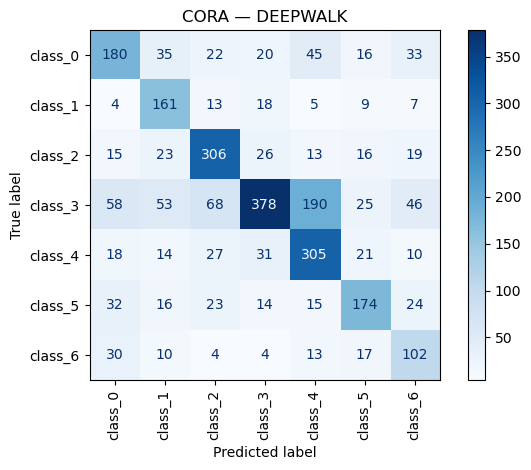

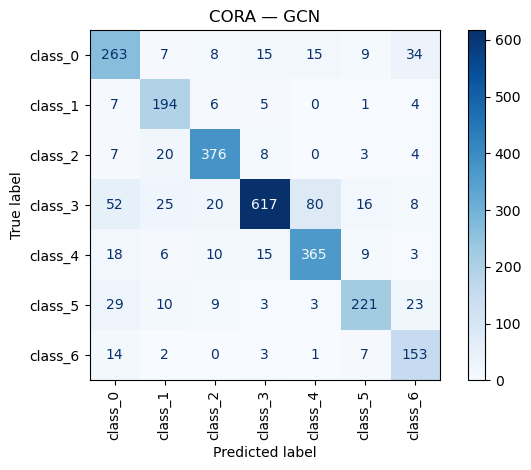


------------------------------------------------------------
Dataset: CITESEER — Confusion Matrices


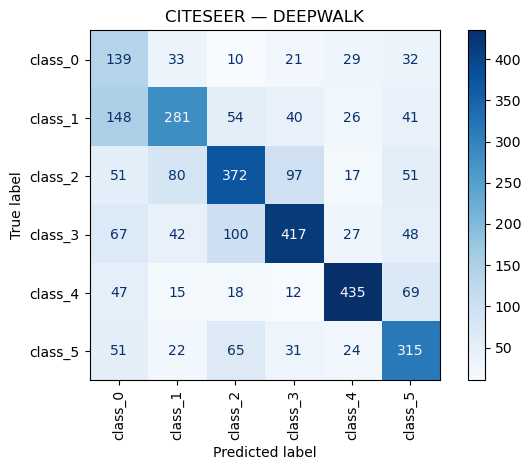

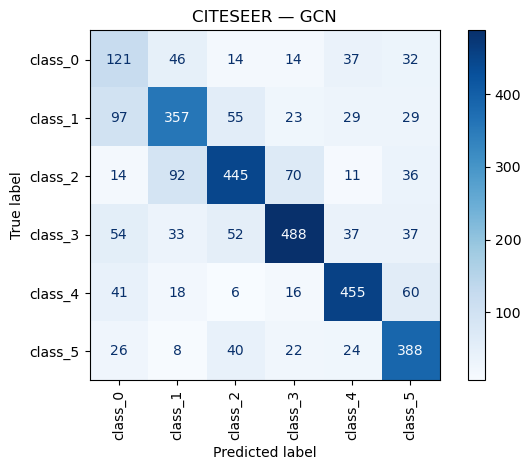

In [91]:
# Plotting Confusion Matrices for DeepWalk & GCN 

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for ds_name in ["cora", "citeseer"]:
    print("\n" + "-" * 60)
    print(f"Dataset: {ds_name.upper()} — Confusion Matrices")

    res_ds = results_all[ds_name]

    
    y_true = np.argmax(res_ds["y_true"], axis=1)
    class_names = res_ds["classes"]

    for model_name in ["deepwalk", "gcn"]:
        y_pred_prob = res_ds[model_name]["pred_all"]
        y_pred = np.argmax(y_pred_prob, axis=1)

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=class_names)
        disp.plot(cmap="Blues", xticks_rotation="vertical")
        plt.title(f"{ds_name.upper()} — {model_name.upper()}")
        plt.tight_layout()
        plt.show()


In [93]:
# Building summary for plot from results_all 

summary_for_plot = {}

for ds_name in ["cora", "citeseer"]:
    res_ds = results_all[ds_name]

    summary_for_plot[ds_name] = {
        "deepwalk": [
            res_ds["deepwalk"]["train"]["accuracy"],
            res_ds["deepwalk"]["val"]["accuracy"],
            res_ds["deepwalk"]["test"]["accuracy"],
        ],
        "gcn": [
            res_ds["gcn"]["train"]["accuracy"],
            res_ds["gcn"]["val"]["accuracy"],
            res_ds["gcn"]["test"]["accuracy"],
        ],
    }

print("summary_for_plot ready:")
summary_for_plot


summary_for_plot ready:


{'cora': {'deepwalk': [1.0, 0.522, 0.576], 'gcn': [1.0, 0.782, 0.8]},
 'citeseer': {'deepwalk': [1.0, 0.56, 0.593], 'gcn': [1.0, 0.676, 0.668]}}

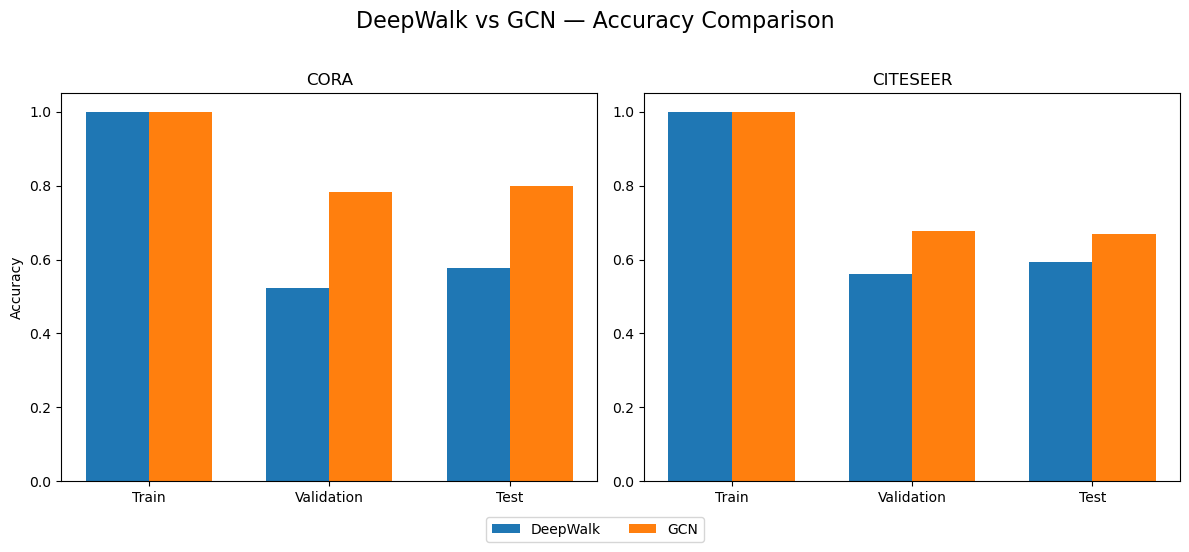

In [95]:
# DeepWalk vs GCN accuracy comparison bar plots (CORA & CITESEER)

import numpy as np
import matplotlib.pyplot as plt

splits = ["Train", "Validation", "Test"]
x = np.arange(len(splits))
bar_width = 0.35

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
dw_cora = summary_for_plot["cora"]["deepwalk"]
gcn_cora = summary_for_plot["cora"]["gcn"]

plt.bar(x - bar_width/2, dw_cora, width=bar_width, label="DeepWalk")
plt.bar(x + bar_width/2, gcn_cora, width=bar_width, label="GCN")

plt.xticks(x, splits)
plt.ylim(0.0, 1.05)
plt.ylabel("Accuracy")
plt.title("CORA")


plt.subplot(1, 2, 2)
dw_cit = summary_for_plot["citeseer"]["deepwalk"]
gcn_cit = summary_for_plot["citeseer"]["gcn"]

plt.bar(x - bar_width/2, dw_cit, width=bar_width, label="DeepWalk")
plt.bar(x + bar_width/2, gcn_cit, width=bar_width, label="GCN")

plt.xticks(x, splits)
plt.ylim(0.0, 1.05)
plt.title("CITESEER")


plt.suptitle("DeepWalk vs GCN — Accuracy Comparison", fontsize=16, y=1.02)

handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(handles, labels,
              loc="upper center", bbox_to_anchor=(0.5, 0.02), ncol=2)

plt.tight_layout()
plt.show()
